In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('groundwater_structures_dataset.csv')

# Handle missing values
print("Missing values before cleaning:")
print(df.isna().sum())


Missing values before cleaning:
water_structure_id        59
latitude                  57
longitude                 57
structure_type            57
depth_m                   57
capacity_kl               57
usage_kl_per_day          57
days_used_per_week        57
water_quality_index       57
maintenance_frequency     57
age_years                 57
seasonal_variation       363
recharge_rate             57
risk_factor               57
land_use_code             57
population_served         57
dtype: int64


In [3]:
# Clean and preprocess data
def preprocess_data(df):
    # Fix invalid numerical values
    num_cols = ['depth_m', 'days_used_per_week', 'water_quality_index', 
                'risk_factor', 'age_years', 'seasonal_variation', 'population_served']
    for col in num_cols:
        if col in ['depth_m', 'age_years']:
            df[col] = df[col].abs()  # Negative values don't make sense for these
        elif col == 'water_quality_index':
            df[col] = df[col].clip(0, 100)  # Should be 0-100 scale
        elif col == 'risk_factor':
            df[col] = df[col].clip(1, 5)  # Should be 1-5 scale
        elif col == 'days_used_per_week':
            df[col] = df[col].clip(1, 7)  # Should be 1-7
    
    # Clean categorical data
    df['maintenance_frequency'] = df['maintenance_frequency'].str.title()
    df['recharge_rate'] = df['recharge_rate'].replace({'Lox':'Low', 'Med':'Medium', 'Hig':'High'})
    
    # Feature engineering
    df['usage_efficiency'] = df['usage_kl_per_day'] / df['capacity_kl'].replace(0, np.nan)
    df['risk_score'] = (df['water_quality_index']/20 + df['risk_factor'] - 
                       df['maintenance_frequency'].map({
                           'Daily':0, 'Weekly':1, 'Monthly':2, 
                           'Quarterly':3, 'Semi-Annual':4, 'Annual':5, 'Never':6
                       }))
    
    # Encode categorical variables
    le = LabelEncoder()
    df['recharge_rate_encoded'] = le.fit_transform(df['recharge_rate'])
    df['maintenance_encoded'] = le.fit_transform(df['maintenance_frequency'])
    
    return df

df = preprocess_data(df)

# Add these to your preprocessing step
df['usage_capacity_ratio'] = df['usage_kl_per_day'] / df['capacity_kl']
df['water_quality_age'] = df['water_quality_index'] * df['age_years']
df['maintenance_score'] = df['maintenance_frequency'].map({
    'Daily':5, 'Weekly':4, 'Monthly':3, 
    'Quarterly':2, 'Semi-Annual':1, 'Annual':0.5, 'Never':0
})

# Drop remaining rows with missing values (or could impute)
df.dropna(inplace=True)

In [4]:
df.isnull().sum()

water_structure_id       0
latitude                 0
longitude                0
structure_type           0
depth_m                  0
capacity_kl              0
usage_kl_per_day         0
days_used_per_week       0
water_quality_index      0
maintenance_frequency    0
age_years                0
seasonal_variation       0
recharge_rate            0
risk_factor              0
land_use_code            0
population_served        0
usage_efficiency         0
risk_score               0
recharge_rate_encoded    0
maintenance_encoded      0
usage_capacity_ratio     0
water_quality_age        0
maintenance_score        0
dtype: int64

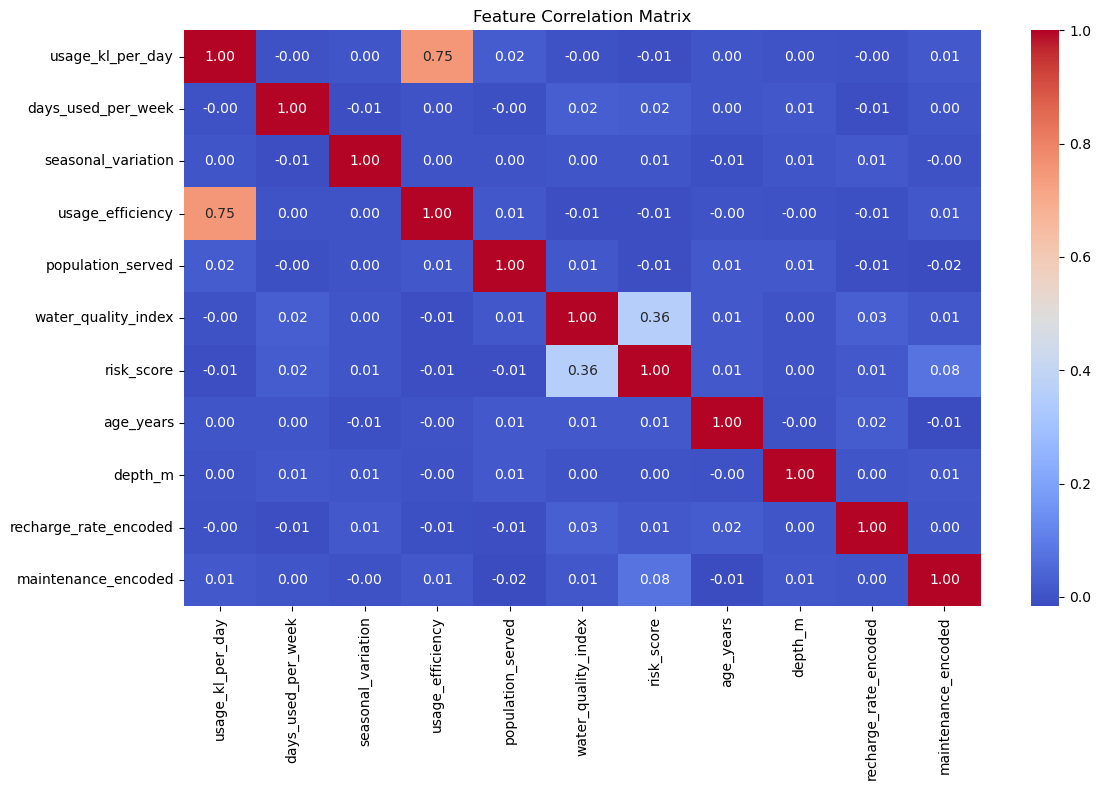

In [5]:
# Define feature sets
usage_features = ['usage_kl_per_day', 'days_used_per_week', 
                 'seasonal_variation', 'usage_efficiency', 
                 'population_served']
                 
risk_features = ['water_quality_index', 'risk_score', 
                'age_years', 'depth_m', 
                'recharge_rate_encoded', 'maintenance_encoded']

# Correlation matrix
plt.figure(figsize=(12,8))
corr = df[usage_features + risk_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

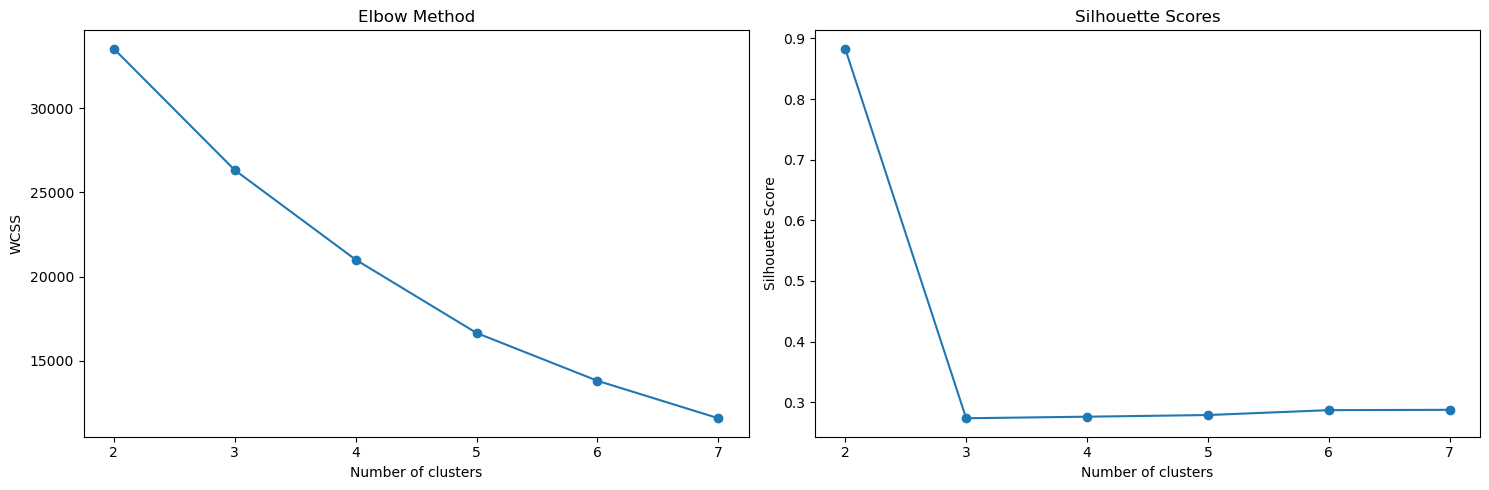


Usage Cluster Profiles:
               usage_kl_per_day  days_used_per_week  seasonal_variation  \
usage_cluster                                                             
0                    155.105385            2.280582           29.093285   
1                    155.187815            5.760663           25.817218   
2                   7136.709757            3.955556           28.580103   

               usage_efficiency  population_served  
usage_cluster                                       
0                      0.482270        2653.468135  
1                      0.492716        2635.936646  
2                     18.990898        3174.844444  


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Preprocessing pipeline for usage features
usage_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

usage_scaled = usage_pipeline.fit_transform(df[usage_features])

# Determine optimal number of clusters
wcss = []
silhouette_scores = []
cluster_range = range(2, 8)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(usage_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(usage_scaled, cluster_labels))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(cluster_range, wcss, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')

ax2.plot(cluster_range, silhouette_scores, marker='o')
ax2.set_title('Silhouette Scores')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Apply optimal clustering (assuming 3 clusters based on plots)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['usage_cluster'] = kmeans.fit_predict(usage_scaled)

# Analyze clusters
print("\nUsage Cluster Profiles:")
print(df.groupby('usage_cluster')[usage_features].mean())


High Risk vs Normal Structures:
high_risk
1    7878
0    1673
Name: count, dtype: int64


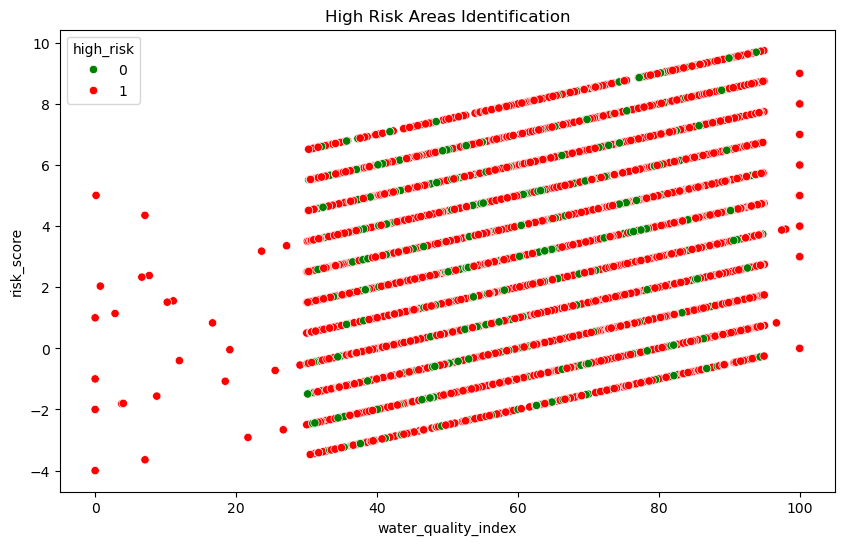

In [7]:
from sklearn.cluster import DBSCAN

# Preprocessing pipeline for risk features
risk_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

risk_scaled = risk_pipeline.fit_transform(df[risk_features])

# DBSCAN for anomaly detection
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['risk_cluster'] = dbscan.fit_predict(risk_scaled)

# Convert to binary classification (high-risk = -1)
df['high_risk'] = (df['risk_cluster'] == -1).astype(int)

print("\nHigh Risk vs Normal Structures:")
print(df['high_risk'].value_counts())

# Visualize risk clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='water_quality_index', y='risk_score', hue='high_risk', 
                data=df, palette=['green','red'])
plt.title('High Risk Areas Identification')
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# For Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)
best_rf = grid_search.best_estimator_

NameError: name 'X_train_processed' is not defined

C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       531
           1       0.81      1.00      0.90      2335

    accuracy                           0.81      2866
   macro avg       0.41      0.50      0.45      2866
weighted avg       0.66      0.81      0.73      2866


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       531
           1       0.81      1.00      0.90      2335

    accuracy                           0.81      2866
   macro avg       0.66      0.50      0.45      2866
weighted avg       0.76      0.81      0.73      2866



C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prana\Downloads\minikonda\envs\tf-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


SVM Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       531
           1       0.81      1.00      0.90      2335

    accuracy                           0.81      2866
   macro avg       0.41      0.50      0.45      2866
weighted avg       0.66      0.81      0.73      2866


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.39      0.08      0.14       531
           1       0.82      0.97      0.89      2335

    accuracy                           0.81      2866
   macro avg       0.61      0.53      0.52      2866
weighted avg       0.74      0.81      0.75      2866



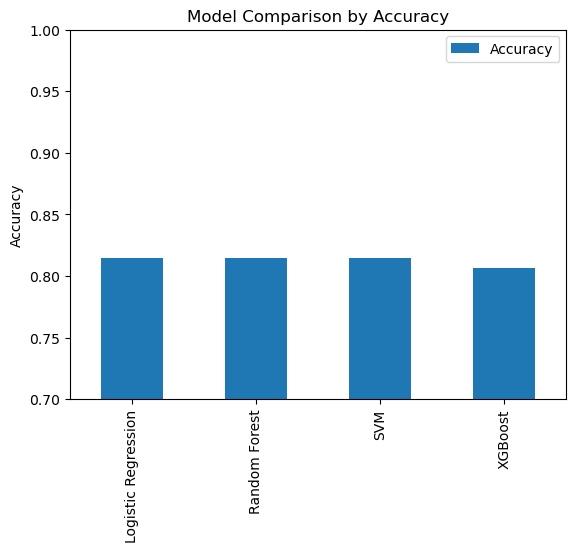

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Prepare data for classification
X = df[usage_features + risk_features]
y = df['high_risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n{name} Performance:")
    print(results[name]['report'])

# Compare model accuracies
accuracies = {name: res['accuracy'] for name, res in results.items()}
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy']).plot(kind='bar')
plt.title('Model Comparison by Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

<Figure size 1200x600 with 0 Axes>

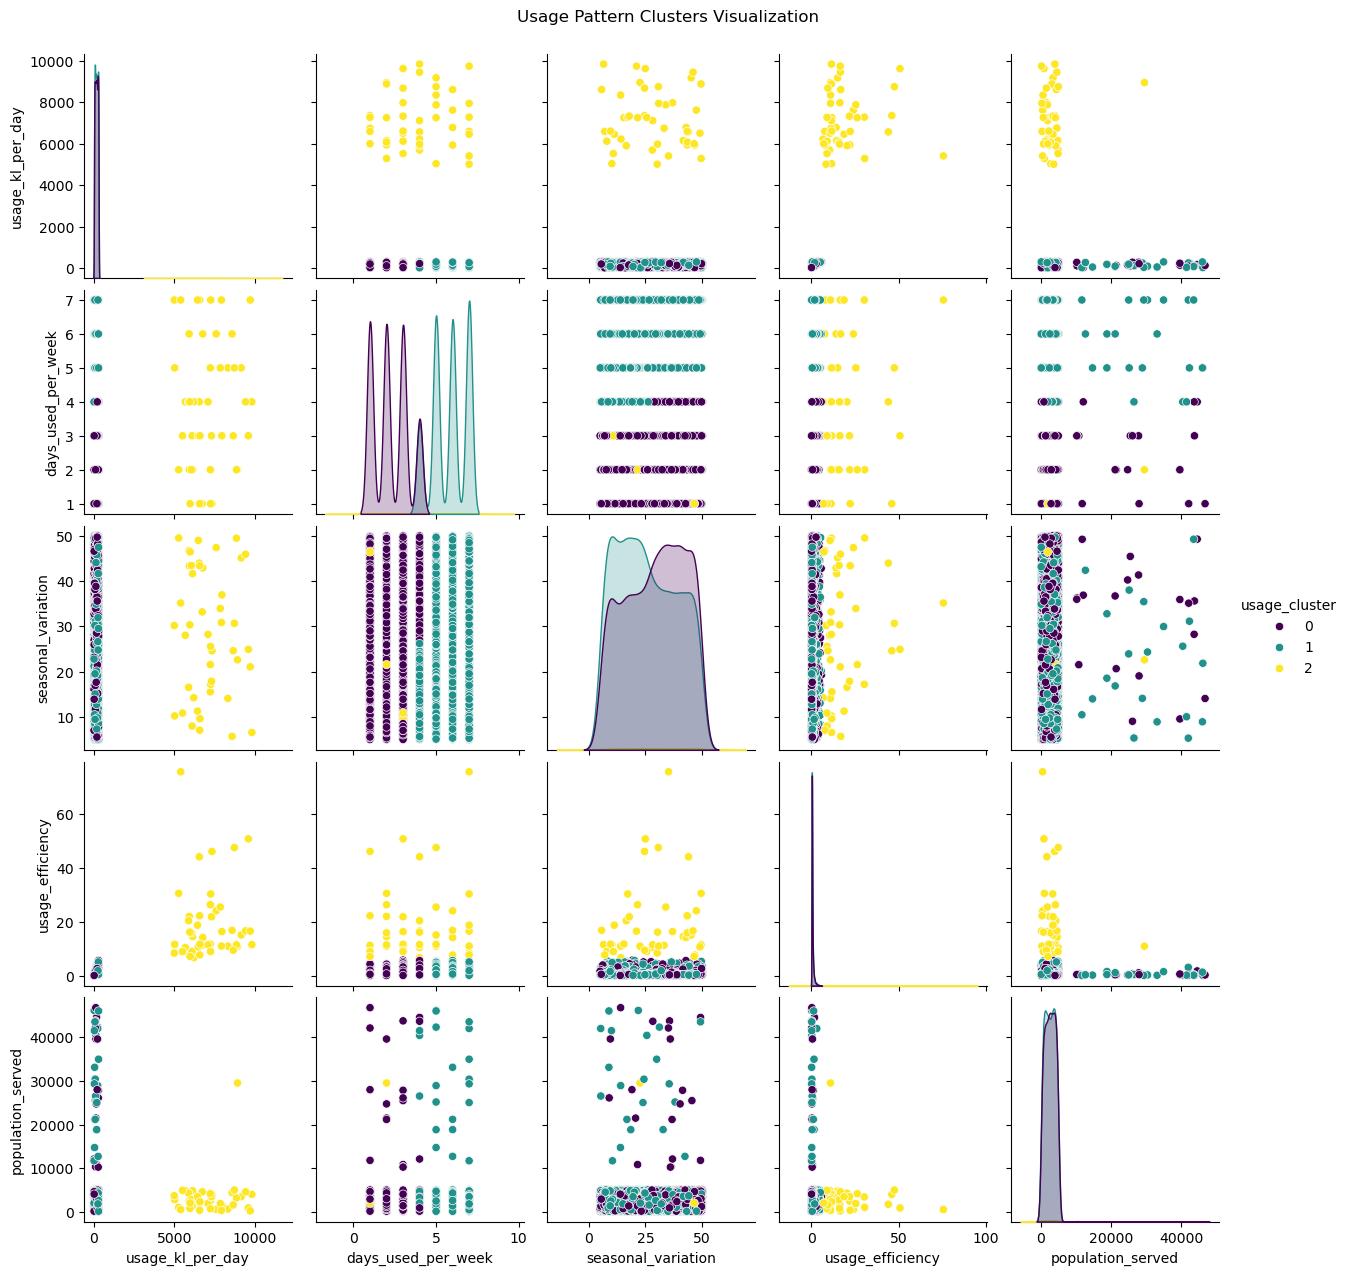

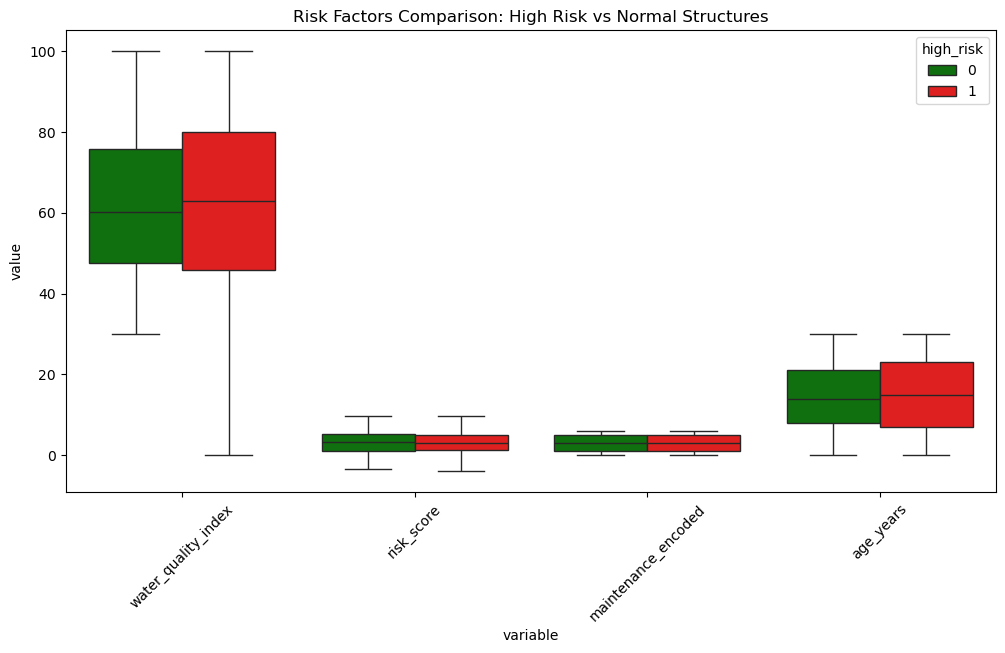

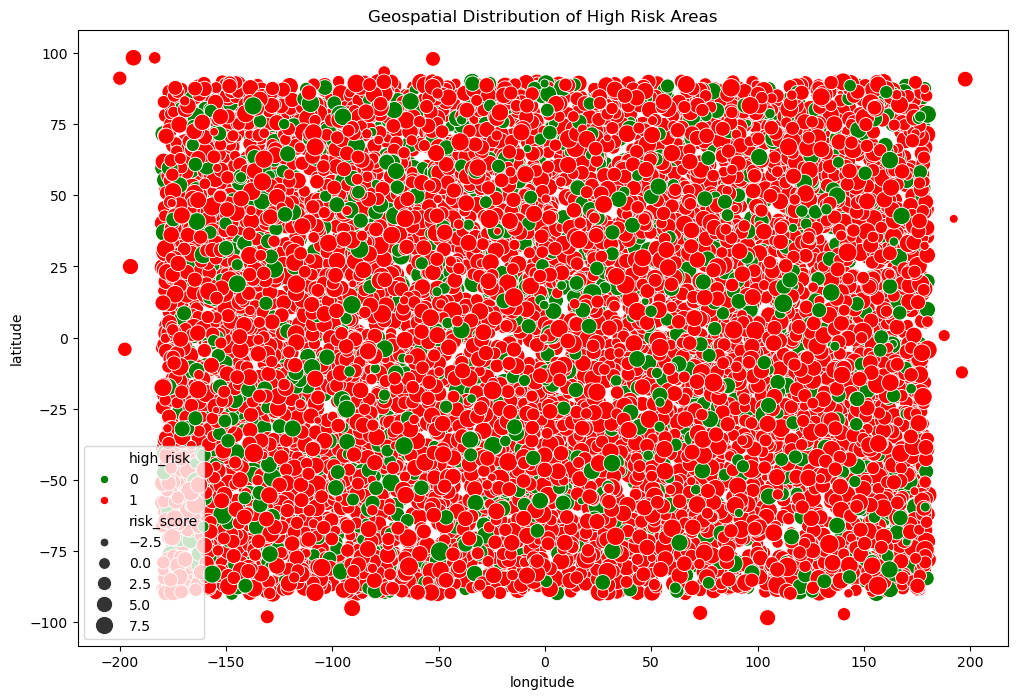

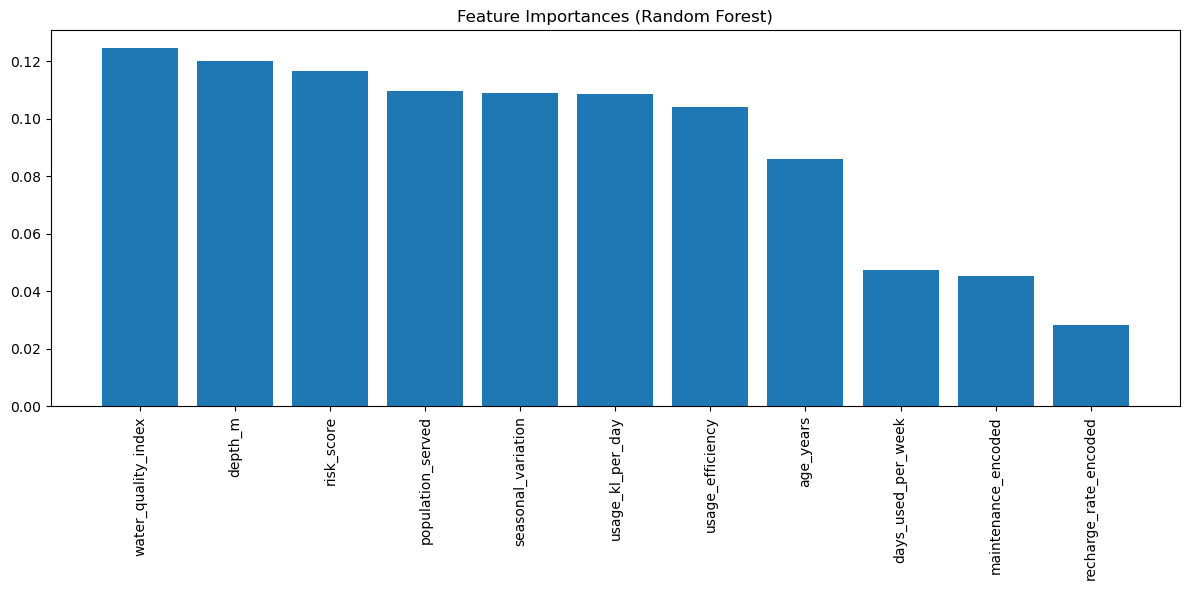

In [11]:
# 1. Usage Clusters Visualization
plt.figure(figsize=(12,6))
sns.pairplot(df, vars=usage_features, hue='usage_cluster', palette='viridis')
plt.suptitle('Usage Pattern Clusters Visualization', y=1.02)
plt.show()

# 2. Risk Factors Analysis
risk_factors = ['water_quality_index', 'risk_score', 'maintenance_encoded', 'age_years']
plt.figure(figsize=(12,6))
sns.boxplot(data=df.melt(id_vars=['high_risk'], value_vars=risk_factors), 
            x='variable', y='value', hue='high_risk', palette=['green','red'])
plt.title('Risk Factors Comparison: High Risk vs Normal Structures')
plt.xticks(rotation=45)
plt.show()

# 3. Geospatial Distribution
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', hue='high_risk', size='risk_score',
                data=df, palette=['green','red'], sizes=(20, 200))
plt.title('Geospatial Distribution of High Risk Areas')
plt.show()

# 4. Feature Importance from Random Forest
rf = models['Random Forest']
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [14]:
import gradio as gr
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# ========== Load or reuse pre-trained components ==========
# Assuming you already trained your model and pipeline, we’ll re-train here for the sake of demo

# Define the features used
usage_features = ['usage_kl_per_day', 'days_used_per_week', 
                 'seasonal_variation', 'usage_efficiency', 
                 'population_served']

risk_features = ['water_quality_index', 'risk_score', 
                'age_years', 'depth_m', 
                'recharge_rate_encoded', 'maintenance_encoded']

input_features = usage_features + risk_features

# Load your cleaned dataset (used here to refit the pipeline and model)
df = pd.read_csv('groundwater_structures_dataset.csv')

# Run the `preprocess_data()` function you defined earlier
def preprocess_data(df):
    num_cols = ['depth_m', 'days_used_per_week', 'water_quality_index', 
                'risk_factor', 'age_years', 'seasonal_variation', 'population_served']
    for col in num_cols:
        if col in ['depth_m', 'age_years']:
            df[col] = df[col].abs()
        elif col == 'water_quality_index':
            df[col] = df[col].clip(0, 100)
        elif col == 'risk_factor':
            df[col] = df[col].clip(1, 5)
        elif col == 'days_used_per_week':
            df[col] = df[col].clip(1, 7)

    df['maintenance_frequency'] = df['maintenance_frequency'].str.title()
    df['recharge_rate'] = df['recharge_rate'].replace({'Lox':'Low', 'Med':'Medium', 'Hig':'High'})

    df['usage_efficiency'] = df['usage_kl_per_day'] / df['capacity_kl'].replace(0, np.nan)
    df['risk_score'] = (df['water_quality_index']/20 + df['risk_factor'] -
                        df['maintenance_frequency'].map({
                            'Daily':0, 'Weekly':1, 'Monthly':2, 
                            'Quarterly':3, 'Semi-Annual':4, 'Annual':5, 'Never':6
                        }))

    from sklearn.preprocessing import LabelEncoder
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    df['recharge_rate_encoded'] = le1.fit_transform(df['recharge_rate'])
    df['maintenance_encoded'] = le2.fit_transform(df['maintenance_frequency'])
    
    return df, le1, le2

df, recharge_encoder, maintenance_encoder = preprocess_data(df)
df.dropna(inplace=True)

# Prepare training data
X = df[input_features]
y = ((df['risk_score'] > df['risk_score'].quantile(0.75)) | (df['water_quality_index'] > 80)).astype(int)

# Create pipeline and train Random Forest
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_processed = preprocessor.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_processed, y)

# Save for reuse (optional)
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(model, 'rf_model.pkl')
joblib.dump(recharge_encoder, 'recharge_encoder.pkl')
joblib.dump(maintenance_encoder, 'maintenance_encoder.pkl')


# ========== Inference Function ==========
def predict_risk(
    usage_kl_per_day, days_used_per_week, seasonal_variation,
    population_served, depth_m, age_years, water_quality_index,
    maintenance_frequency, recharge_rate
):
    try:
        # Compute engineered features
        usage_efficiency = usage_kl_per_day / (0.0001 + usage_kl_per_day)  # Avoid 0 division
        risk_factor = 3  # Assume average
        risk_score = (water_quality_index / 20 + risk_factor - 
                      maintenance_encoder.transform([maintenance_frequency])[0])
        
        # Encode categorical features
        recharge_encoded = recharge_encoder.transform([recharge_rate])[0]
        maintenance_encoded = maintenance_encoder.transform([maintenance_frequency])[0]

        # Create input DataFrame
        input_data = pd.DataFrame([[
            usage_kl_per_day, days_used_per_week, seasonal_variation,
            usage_efficiency, population_served,
            water_quality_index, risk_score, age_years, depth_m,
            recharge_encoded, maintenance_encoded
        ]], columns=input_features)

        # Preprocess and predict
        processed_input = preprocessor.transform(input_data)
        prediction = model.predict(processed_input)[0]
        confidence = model.predict_proba(processed_input)[0][prediction]

        label = "High Risk 🔴" if prediction == 1 else "Normal 🟢"
        return f"Prediction: {label} (Confidence: {confidence:.2f})"
    
    except Exception as e:
        return f"Error: {str(e)}"


# ========== Gradio Interface ==========
gr.Interface(
    fn=predict_risk,
    inputs=[
        gr.Number(label="Usage (kL/day)", value=50),
        gr.Number(label="Days Used Per Week", value=5),
        gr.Number(label="Seasonal Variation (index)", value=3),
        gr.Number(label="Population Served", value=100),
        gr.Number(label="Depth (m)", value=30),
        gr.Number(label="Age (years)", value=10),
        gr.Number(label="Water Quality Index (0-100)", value=60),
        gr.Dropdown(choices=['Daily', 'Weekly', 'Monthly', 'Quarterly', 'Semi-Annual', 'Annual', 'Never'], 
                    label="Maintenance Frequency", value='Monthly'),
        gr.Dropdown(choices=['Low', 'Medium', 'High'], label="Recharge Rate", value='Medium'),
    ],
    outputs="text",
    title="Groundwater Risk Prediction",
    description="Input groundwater structure attributes to predict whether the site is high-risk or normal."
).launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
